# 3D fruit slice example
- Soichiro Nishiyama 22/01/30
- 横切り+縦切りの自動スクリプト
- step-by-stepはsingleのスクリプトを参照
- 縦切りと、横切りの溝の交点ベースの手法を実装 (2022/01/30)
- 横切りのときに、輪郭が沢山でてきたとき、最大のものを選ぶところの実装 (2022/01/30)
- 縦切りの向きを合わせるコードを修正 (2022/01/31)
- 横切り溝の交点ベースの手法の可視化コードを実装 (2022/01/31)
- 縦切りの向きを手動で合わせるコードを追加 (2022/02/03)
- 横切りの交点ベースの手法を、x=0,y=0でなく、点を移動させて最大をとるように改良 (2022/02/06)
- `3D_fruit_slicing_groove_point_detection_automated.ipynb`に名前変更 (2022/03/24)
- へたの位置をもとに横切りの順番を修正するコードを追加 (2022/03/25)
- polygons_closedでエラーが出るものがあったため、面積最大のpolygonの出し方を調整 (select_largest_polygon) (22/03/28)
- モジュール化 (22/03/30)
- 座の検出 (22/03/31)
- 手動で向きを変える & 除くコードの追加 (22/04/01)
- 座のパラメータを検出座点ごとにだすように変更 (22/05/26)
- 座の三次元計測を追加 (22/05/31)
## requirements
- trimesh
- shapely
- numpy
- matplotlib
- descartes
- python-polylabel
- そのほかあるかも・・・
- boolean operationにblenderを使うので、インストールが必要

## references
- https://techblog.zozo.com/entry/zozomat-trimesh
- https://trimsh.org/examples/section.html
- https://github.com/mikedh/trimesh
- https://shapely.readthedocs.io/en/stable/manual.html#object.convex_hull
- ほとんどtrimeshのexample codeと同じ
- 外接円
    - https://www.nayuki.io/page/smallest-enclosing-circle
- 内接円
    - https://github.com/Twista/python-polylabel
    - shapelyのpolylabelでcentroidとpolylineの距離が出せなかったため、上記を使用
    

In [1]:
import numpy as np
import trimesh
import shapely
#%pylab inline
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from descartes.patch import PolygonPatch
from matplotlib import pyplot as plt
from matplotlib import patches
import cv2
import smallestenclosingcircle
from polylabel import polylabel
import glob
import os
import math
import copy
# import proc2d as pr2
# import proc3d as pr3
# import fruit_2d_measurement as p2m
import proc2d_230903 as pr2
import proc3d_220608 as pr3
import fruit_2d_measurement_220608 as p2m
import statistics
from operator import itemgetter
import pandas as pd

# vert slicing
- rotation_axisを中心に180度分回転してスライスする。
- rotation_axis: 回転軸、x=0, y=1, z=2
- init_point: 最初の回転面を指定する。0:[1,0,0], 1:[0,1,0], 2:[0,0,1]。これが法線ベクトルであり、メッシュのcentroidを通る面が最初のスライス面になる。
- num_sect: スライス数
- へたの位置をconvexity defectで同定し、その場所によって輪郭を回転させて向き合わせ

In [2]:
def show_vert_slice_sections(sections):
    fig = plt.figure(1,figsize = (10,10))
    num_sect = len(sections)
    step = 1
    horizontal_count = 5
    vertical_count = int(num_sect/step/horizontal_count)
    curr = 0
    for i in range(0,num_sect,step):
        curr += 1
        sect = sections[i]
        if sect == None:
            continue
        [[xmin,ymin],[xmax,ymax]] = sections[i].bounds
        ax = fig.add_subplot(vertical_count,horizontal_count,curr)
        ax.set_aspect('equal')
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(xmin,xmax)
        ax.set_title("section "+str(i),fontsize=5)
        ax.tick_params(labelsize=5)
        sect_polygon = sect.polygons_full
        if len(sect_polygon) == 0:
            continue
        for j in range(len(sect_polygon)):
            patch = patches.Polygon(sect_polygon[j].exterior.coords,fc='r', ec='k', alpha=0.5)
            ax.add_patch(patch)

    fig.tight_layout()
    ax.plot()    

In [3]:
def show_rotation(sect_ori, sect_rotated):
    fig = plt.figure(1,figsize = (5,5))
    [[xmin,ymin],[xmax,ymax]] = sect.bounds
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_aspect('equal')
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(xmin,xmax)
    ax1.set_title("section "+str(i)+" original",fontsize=5)
    ax1.tick_params(labelsize=5)

    sect_polygon = sect_ori.polygons_full
    patch1 = patches.Polygon(sect_polygon[0].exterior.coords,fc='r', ec='k', alpha=0.5)
    ax1.add_patch(patch1)

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_aspect('equal')
    ax2.set_ylim(ymin,ymax)
    ax2.set_xlim(xmin,xmax)
    ax2.set_title("section "+str(i)+" rotated",fontsize=5)
    ax2.tick_params(labelsize=5)

    sect_polygon = sect_rotated.polygons_full
    patch2 = patches.Polygon(sect_polygon[0].exterior.coords,fc='r', ec='k', alpha=0.5)
    ax2.add_patch(patch2)
    fig.show()

In [4]:
def rotation_matrix(t):
    """
    generate 2D rotation matrix
    t: degree
    """
    rad = np.deg2rad(t)
    R = np.array([[np.cos(rad), -np.sin(rad),0],
                  [np.sin(rad),  np.cos(rad),0],
                  [0,0,1]])
    return R

# main

In [5]:
cultivar = "10_169_tamopan"
files = sorted(glob.glob("./230201_paper/169_tamopan/10/*.stl"))
file_count = len(files)
sample_name = [i.split('/')[-1].split('.')[0] for i in files]

In [6]:
t_num_sect = 100
v_num_sect = 30

In [7]:
res_area = np.zeros((t_num_sect,file_count))
res_convexity = np.zeros((t_num_sect,file_count))
res_convexity_e = np.zeros((t_num_sect,file_count))
res_depth = np.zeros((t_num_sect,file_count))
res_round = np.zeros((t_num_sect,file_count))
res_tg_angle = np.zeros((v_num_sect*2,file_count))
res_tg_cvd = np.zeros((v_num_sect*2,file_count))
res_tg_h = np.zeros((v_num_sect*2,file_count))
res_hg_area = np.zeros(file_count)
res_hg_rel_area = np.zeros(file_count)
res_hg_vol = np.zeros(file_count)
res_hg_rel_vol = np.zeros(file_count)
res_hg_dist = []

In [8]:
do_obb = True

In [9]:
vstacks = []
tstacks = []
to3dss = []
obb2dss = []
t_axiss = []
meshs = []
res_LW_aver = []
res_LW_std = []
res_varea_aver = []
res_varea_std = []

201_paper/169_tamopan/10/10_169-tamopan-01.stl


/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


selected horizontal plane #0
selected vetical plane #1


/share/2021_fruit_3d/proc3d_220608.py:40: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d3 = abs(y_inters[0].coords.xy[1][0]-ymin)
/share/2021_fruit_3d/proc3d_220608.py:41: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d4 = abs(y_inters[1].coords.xy[1][0]-ymax)
/share/2021_fruit_3d/proc3d_220608.py:42: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if y_inters[np.argmax([d3,d4])].coords.xy[1][0] >= 0: # y>=0にへた部があるなら
/share/2021_fruit_3d/proc2d_230903.py:145: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is

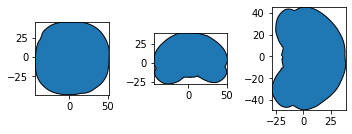

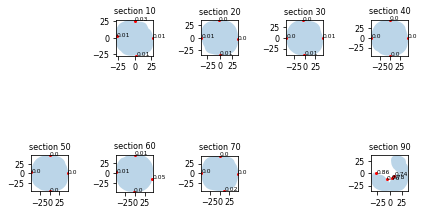

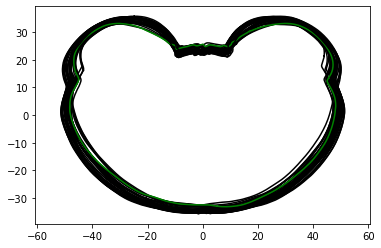

Vertical section area average:5377.4295, sd:261.208



/share/2021_fruit_3d/proc2d_230903.py:207: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.pol = pol
/share/2021_fruit_3d/proc2d_230903.py:284: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_o = STRtree(sec_dif)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = list(geoms)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = list(geoms)
/sha

1st round gp detection: 55 / 60 points
2nd round gp detection: 60 / 60 points
201_paper/169_tamopan/10/10_169-tamopan-02.stl


/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


selected horizontal plane #0
selected vetical plane #1


/share/2021_fruit_3d/proc3d_220608.py:40: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d3 = abs(y_inters[0].coords.xy[1][0]-ymin)
/share/2021_fruit_3d/proc3d_220608.py:41: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d4 = abs(y_inters[1].coords.xy[1][0]-ymax)
/share/2021_fruit_3d/proc3d_220608.py:42: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if y_inters[np.argmax([d3,d4])].coords.xy[1][0] >= 0: # y>=0にへた部があるなら
/share/2021_fruit_3d/proc2d_230903.py:145: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is

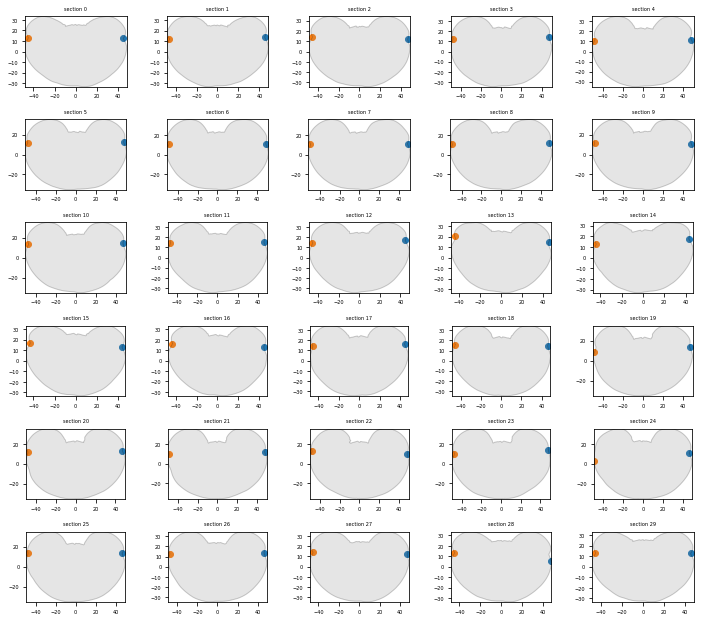

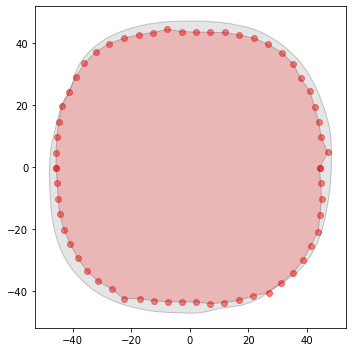

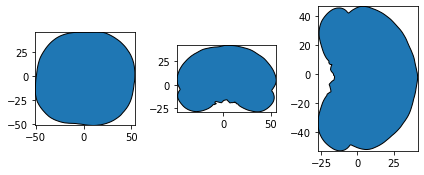

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


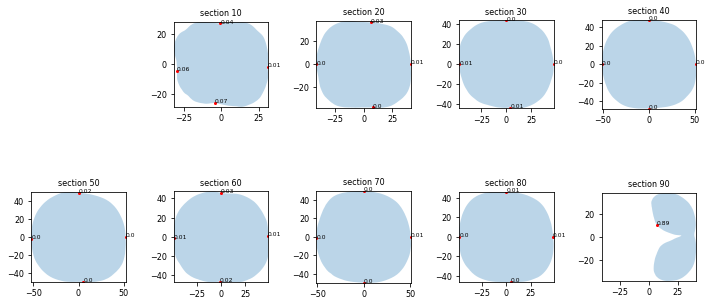

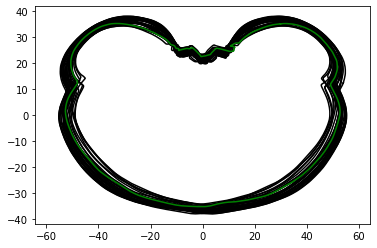

/share/2021_fruit_3d/proc2d_230903.py:207: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.pol = pol
/share/2021_fruit_3d/proc2d_230903.py:284: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_o = STRtree(sec_dif)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = list(geoms)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = list(geoms)
/sha

Vertical section area average:6063.4956, sd:360.2179



/share/2021_fruit_3d/proc2d_230903.py:295: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(pol_search)


1st round gp detection: 58 / 60 points


/root/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


2nd round gp detection: 60 / 60 points
201_paper/169_tamopan/10/10_169-tamopan-03.stl


/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


selected horizontal plane #0
selected vetical plane #1


/share/2021_fruit_3d/proc3d_220608.py:40: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d3 = abs(y_inters[0].coords.xy[1][0]-ymin)
/share/2021_fruit_3d/proc3d_220608.py:41: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d4 = abs(y_inters[1].coords.xy[1][0]-ymax)
/share/2021_fruit_3d/proc3d_220608.py:42: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if y_inters[np.argmax([d3,d4])].coords.xy[1][0] >= 0: # y>=0にへた部があるなら
/share/2021_fruit_3d/proc2d_230903.py:145: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is

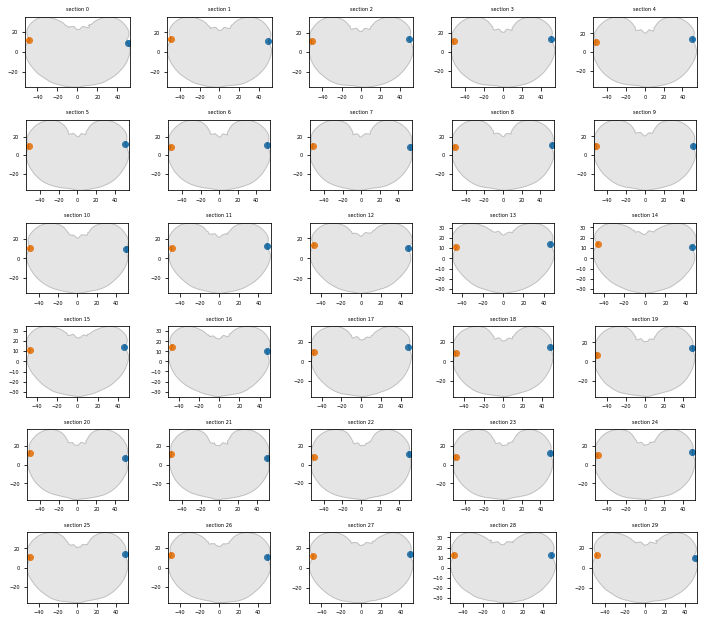

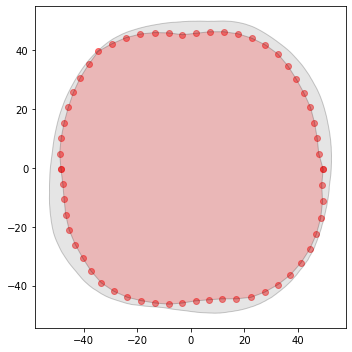

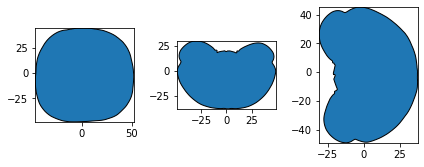

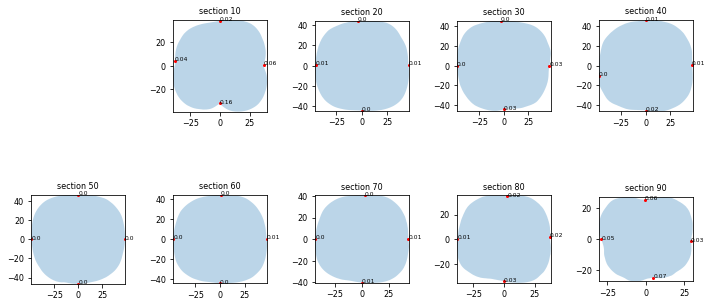

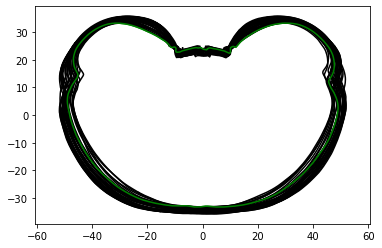

Vertical section area average:5507.4753, sd:310.2129



/share/2021_fruit_3d/proc2d_230903.py:207: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.pol = pol
/share/2021_fruit_3d/proc2d_230903.py:284: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_o = STRtree(sec_dif)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = list(geoms)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = list(geoms)
/sha

1st round gp detection: 57 / 60 points


/root/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


2nd round gp detection: 59 / 60 points
201_paper/169_tamopan/10/10_169-tamopan-04.stl


/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


selected horizontal plane #0
selected vetical plane #1


/share/2021_fruit_3d/proc3d_220608.py:40: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d3 = abs(y_inters[0].coords.xy[1][0]-ymin)
/share/2021_fruit_3d/proc3d_220608.py:41: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d4 = abs(y_inters[1].coords.xy[1][0]-ymax)
/share/2021_fruit_3d/proc3d_220608.py:42: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if y_inters[np.argmax([d3,d4])].coords.xy[1][0] >= 0: # y>=0にへた部があるなら
/share/2021_fruit_3d/proc2d_230903.py:145: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is

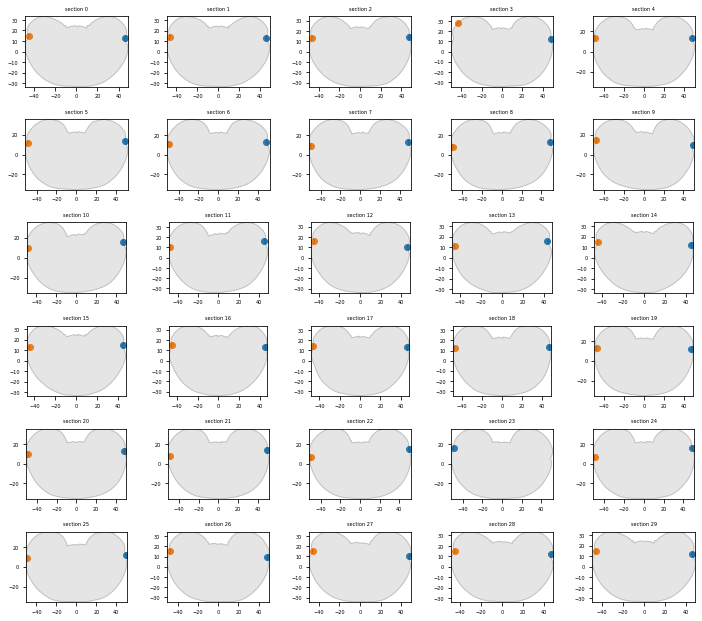

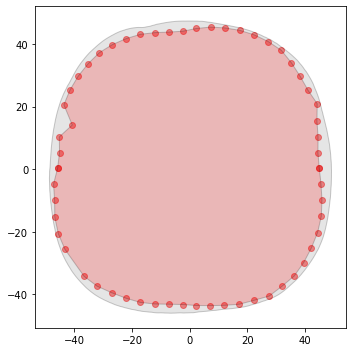

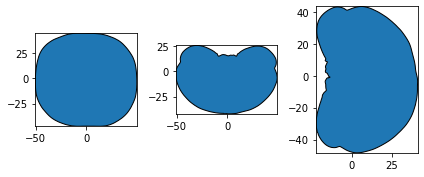

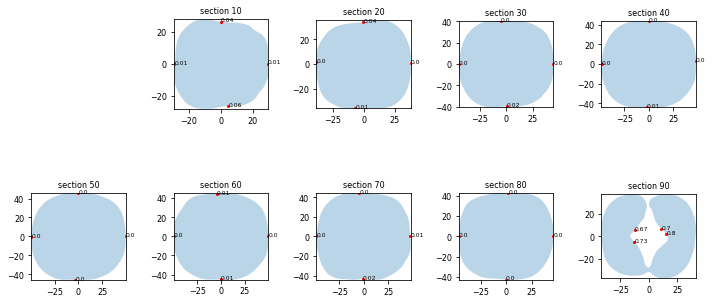

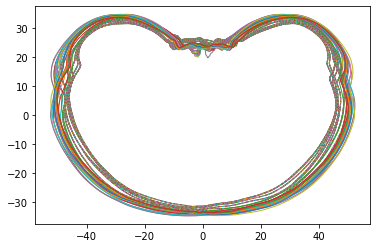

Vertical section area average:5392.4949, sd:334.0128



/share/2021_fruit_3d/proc2d_230903.py:207: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.pol = pol
/share/2021_fruit_3d/proc2d_230903.py:284: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_o = STRtree(sec_dif)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = list(geoms)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = list(geoms)
/sha

1st round gp detection: 52 / 60 points


/root/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


2nd round gp detection: 57 / 60 points
201_paper/169_tamopan/10/10_169-tamopan-05.stl


/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/root/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


selected horizontal plane #0
selected vetical plane #1


/share/2021_fruit_3d/proc3d_220608.py:40: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d3 = abs(y_inters[0].coords.xy[1][0]-ymin)
/share/2021_fruit_3d/proc3d_220608.py:41: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d4 = abs(y_inters[1].coords.xy[1][0]-ymax)
/share/2021_fruit_3d/proc3d_220608.py:42: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if y_inters[np.argmax([d3,d4])].coords.xy[1][0] >= 0: # y>=0にへた部があるなら
/share/2021_fruit_3d/proc2d_230903.py:145: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is

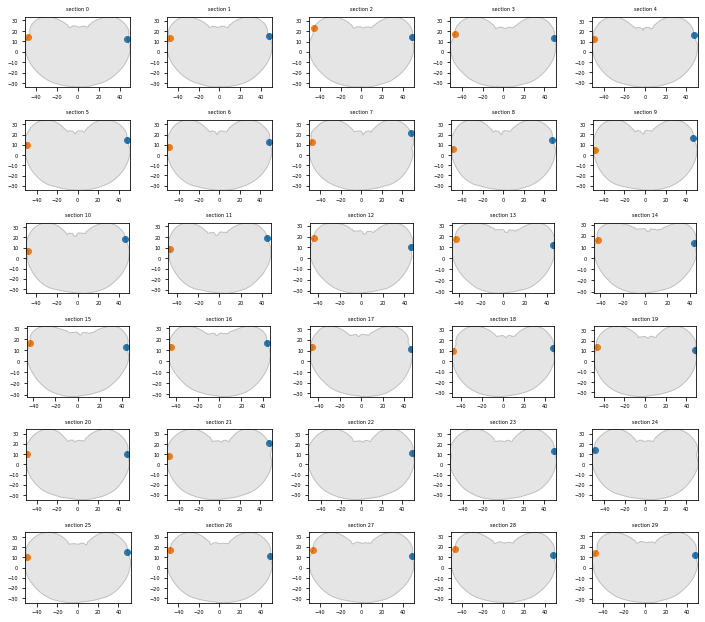

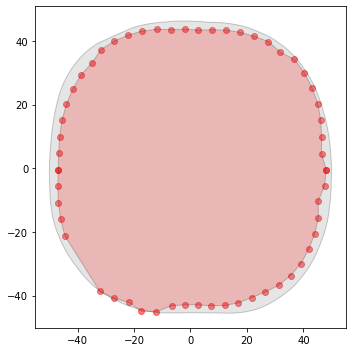

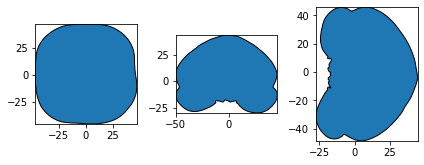

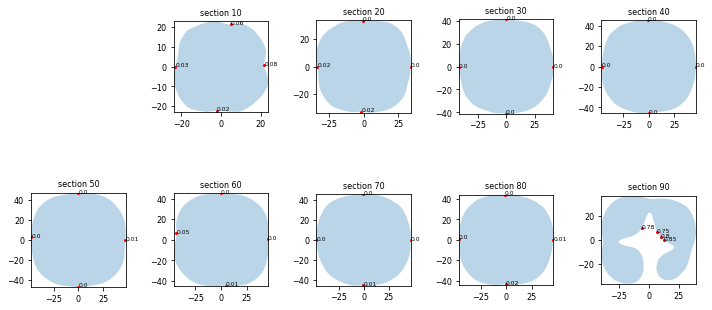

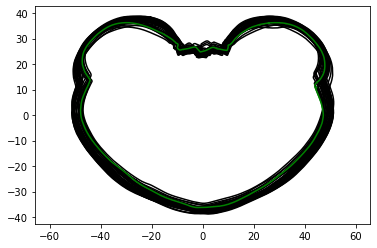

Vertical section area average:5676.6844, sd:294.3405



/share/2021_fruit_3d/proc2d_230903.py:207: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.pol = pol
/share/2021_fruit_3d/proc2d_230903.py:284: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_o = STRtree(sec_dif)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = list(geoms)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/shapely/strtree.py:118: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = list(geoms)
/sha

1st round gp detection: 56 / 60 points


/root/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


2nd round gp detection: 60 / 60 points


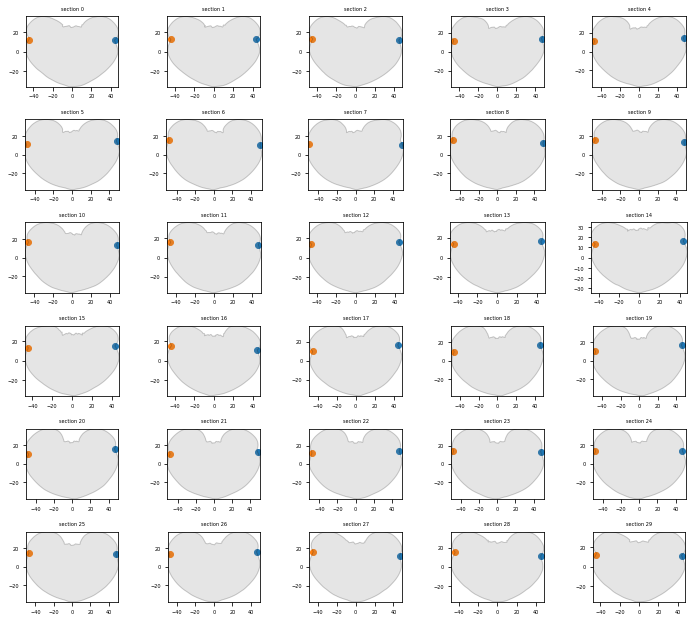

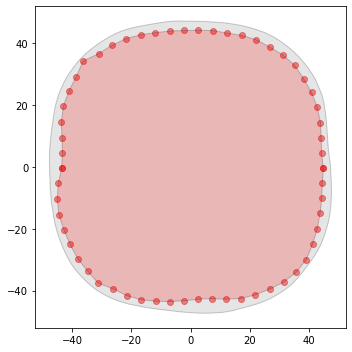

In [10]:
for i in range(file_count):
    stl = files[i]
    print(stl[5:])
    mesh = trimesh.load_mesh(stl, process=False)
    mesh.process(validate=True) # remove broken faces 22/05/30
    mesh.fill_holes()
    
    # bboxベースで切る面を見つける
    ###
    if do_obb:
        mesh = pr3.obb_transform(mesh)
    plt.figure()
    mesh, ld = p2m.show_center_sliced_section(mesh)
    
    t_axis = ld.index(min(ld))
    if t_axis == 0:
        v_axis = 1
    else:
        v_axis = 0
    print("selected horizontal plane #"+str(t_axis))
    print("selected vetical plane #"+str(v_axis))
    t_axiss.append(t_axis)
    ###
    
    # 決まった面で切る、必要に応じて値を変更
    # 出てくる図の左から0,1,2
    ###
#     t_axis = 2
#     v_axis = 0
#     p2m.show_center_sliced_section(mesh)
#     ###
    
    ### trans slicing & measurement
    trans_sections = pr3.trans_slicing(mesh, t_axis, t_num_sect)
    t_conv = pr3.if_trans_coordinate(mesh, v_axis)
    t_sects = pr2.Sections(trans_sections)
    t_sects.trans_coordinate_direction(t_conv)

    sect_area = t_sects.transverse_area()
    sect_convex = t_sects.convexity_defects_area()
    sect_convex_e = t_sects.convexity_defects_area_e()
    sect_depth = t_sects.depth_by_intersection_vis(10) # 0で可視化オフ
    sect_roundness = t_sects.roundness()
    
    res_area[:,i] = sect_area   
    res_convexity[:,i] = sect_convex
    res_convexity_e[:,i] = sect_convex_e
    res_depth[:,i] = sect_depth
    res_round[:,i] = sect_roundness
    
    tstacks.append(trans_sections)
    ###
    
    ### vert slicing & measurement
    vert_sections, to3ds, obb2ds = pr3.vert_slicing(mesh,t_axis,v_axis,v_num_sect)
    to3dss.append(to3ds)
    obb2dss.append(obb2ds)
    v_sects = pr2.Sections(vert_sections)
    vert_oriented_sections, rotates = v_sects.vert_coordinate_direction()
    v_oriented_sects = pr2.Sections(vert_oriented_sections)
    v_oriented_sects.show_combined_sections()

    vert_lw = v_oriented_sects.vert_get_lw()
#     print("L/W average:"+str(round(np.average(vert_lw),4))+", sd:"+str(round(np.std(vert_lw),4))+"\n")
    vstacks.append(vert_oriented_sections)
    
    vert_varea =v_oriented_sects.vert_sect_area()
    print("Vertical section area average:"+str(round(np.average(vert_varea),4))+", sd:"+str(round(np.std(vert_varea),4))+"\n")
    vstacks.append(vert_oriented_sections)
    
    tg_angle,tg_cvd,tg_h,tgroove_p1,tgroove_p2 = v_oriented_sects.v_horizontal_groove(init_limit=0.3, resolution=0.5,npo=2,cda_thre=0.0000001)
    res_tg_angle[:,i] = tg_angle
    res_tg_cvd[:,i] = tg_cvd
    res_tg_h[:,i] = tg_h
    
    hgps = pr3.Hgps(mesh,tgroove_p1,tgroove_p2,t_axis,rotates,obb2ds,to3ds)
    hg_area, hg_rel_area, hg_vol, hg_rel_vol, hg_dist = hgps.hgps_process()
    res_hg_area[i] = hg_area
    res_hg_rel_area[i] = hg_rel_area
    res_hg_vol[i] = hg_vol
    res_hg_rel_vol[i] = hg_rel_vol
    res_hg_dist.append(hg_dist)
    res_LW_aver.append(statistics.mean(vert_lw))
    res_varea_aver.append(statistics.mean(vert_varea))
    ###
#     res_LW_aver.append(average(vert_lw))
    ###
    res_LW_std.append(np.std(vert_lw))
    res_varea_std.append(np.std(vert_varea))
    
    meshs.append(mesh)

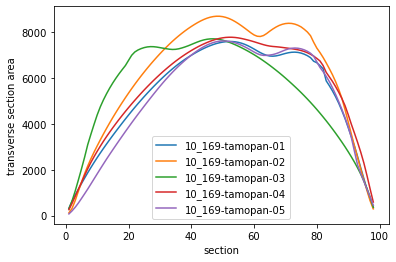

In [11]:
x = list(range(0, t_num_sect))

fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.plot(x, res_area[:,i], label=sample_name[i])
ax.legend()
ax.set_xlabel("section")
ax.set_ylabel("transverse section area")
plt.show()

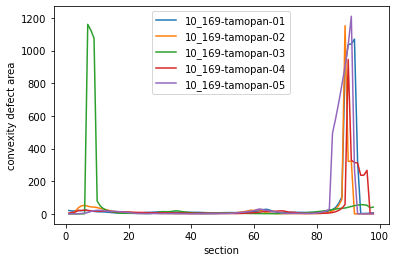

In [12]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.plot(x, res_convexity[:,i], label=sample_name[i])
ax.legend()
ax.set_xlabel("section")
ax.set_ylabel("convexity defect area")
plt.show()

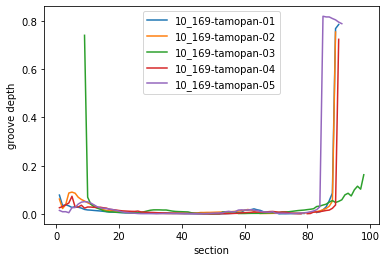

In [13]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.plot(x, res_depth[:,i], label=sample_name[i])
ax.legend()
ax.set_xlabel("section")
ax.set_ylabel("groove depth")
plt.show()

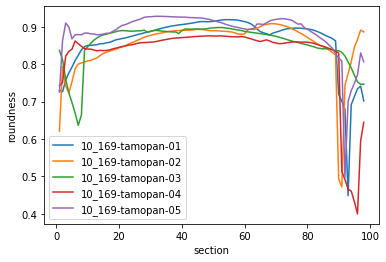

In [14]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.plot(x, res_round[:,i], label=sample_name[i])
ax.legend()
ax.set_xlabel("section")
ax.set_ylabel("roundness")
plt.show()

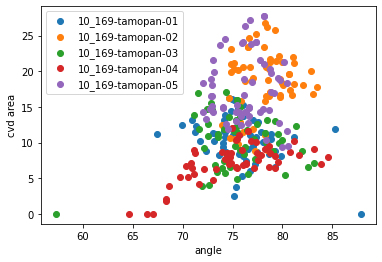

In [15]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.scatter(res_tg_angle[:,i],res_tg_cvd[:,i],label=sample_name[i])
ax.legend()
ax.set_xlabel("angle")
ax.set_ylabel("cvd area")
plt.savefig(cultivar+"_angle_vs_cvdarea.pdf")
plt.show()

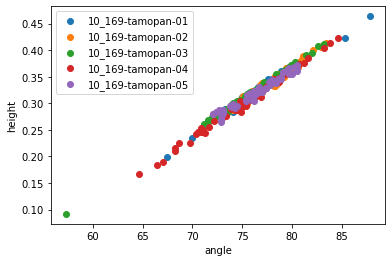

In [16]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.scatter(res_tg_angle[:,i],res_tg_h[:,i],label=sample_name[i])
ax.legend()
ax.set_xlabel("angle")
ax.set_ylabel("height")
plt.show()

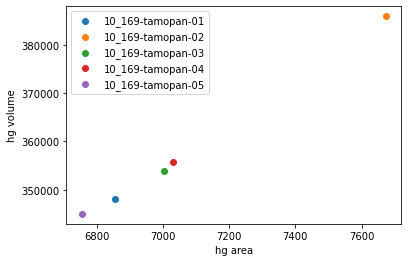

In [17]:
fig, ax = plt.subplots(facecolor="w")
for i in range(file_count):
    ax.scatter(res_hg_area[i],res_hg_vol[i],label=sample_name[i])
ax.legend()
ax.set_xlabel("hg area")
ax.set_ylabel("hg volume")
plt.savefig(cultivar+"_hgarea_vs_hgvolume.pdf")
plt.show()

In [ ]:
# fig, ax = plt.subplots(facecolor="w")
# for i in range(file_count):
#     ax.scatter(res_hg_rel_area[i],res_hg_rel_vol[i],label=sample_name[i])
# ax.legend()
# ax.set_xlabel("hg relative area")
# ax.set_ylabel("hg relative volume")
# plt.savefig(cultivar+"_hgrelarea_vs_hgrelvolume.pdf")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(facecolor="w")
# ax.boxplot(res_hg_dist)
# ax.legend()
# ax.set_title("Euclidean distance between tgp and centroid")
# ax.set_xticklabels(sample_name)
# plt.savefig(cultivar+"_hgdist.pdf")
# plt.show()

# manual coordination of trans slices
- 横切りで向きが合わないときに以下を検討
1. ターゲットのメッシュを指定（sample_nameに名前が入っているので、そのインデックスで指定）
2. 全データを逆向きにする

In [ ]:
# # 1
# mesh_idx = 0
# print("modify: "+sample_name[mesh_idx])

In [ ]:
# # 2
# res_area[:,0] = res_area[:,0][::-1]
# res_convexity[:,0] = res_convexity[:,0][::-1]
# res_depth[:,0] = res_depth[:,0][::-1]
# res_round[:,0] = res_round[:,0][::-1]

In [18]:
mesh_idx = [0,1,3,4]
for i in mesh_idx:
    print("modify: "+sample_name[i])
#     res_area[:,i] = res_area[:,0][::-1]
#     res_convexity[:,i] = res_convexity[:,0][::-1]
#     res_depth[:,i] = res_depth[:,0][::-1]
#     res_round[:,i] = res_round[:,0][::-1]
    res_area[:,i] = res_area[:,i][::-1]
    res_convexity[:,i] = res_convexity[:,i][::-1]
    res_convexity_e[:,i] = res_convexity_e[:,i][::-1]
    res_depth[:,i] = res_depth[:,i][::-1]
    res_round[:,i] = res_round[:,i][::-1]

modify: 10_169-tamopan-01
modify: 10_169-tamopan-02
modify: 10_169-tamopan-04
modify: 10_169-tamopan-05


# save

In [ ]:
# with open(cultivar+"_LW_aver.csv", 'w') as f:
#     np.savetxt(f, res_LW_aver,delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_LW_std.csv", 'w') as f:
#     np.savetxt(f, res_LW_std,delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_section_area.csv", 'w') as f:
#     np.savetxt(f, res_area,delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_convexity_defect.csv", 'w') as f:
#     np.savetxt(f, res_convexity,delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_conv_area.csv", 'w') as f:
#     np.savetxt(f, res_convexity_e, delimiter=',',header=",".join(sample_name),comments="")  
# with open(cultivar+"_roundness.csv", 'w') as f:
#     np.savetxt(f, res_round, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_groove_depth.csv", 'w') as f:
#     np.savetxt(f, res_depth, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_tg_angle.csv", 'w') as f:
#     np.savetxt(f, res_tg_angle, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_tg_cvd.csv", 'w') as f:
#     np.savetxt(f, res_tg_cvd, delimiter=',',header=",".join(sample_name),comments="")
# # with open(cultivar+"_tg_height.csv", 'w') as f:
# #     np.savetxt(f, res_tg_h, delimiter=',',header=",".join(sample_name),comments="")

with open(cultivar+"_hg_area_standardized.csv", 'w') as f:
    np.savetxt(f, res_hg_area, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_hg_rel_area.csv", 'w') as f:
#     np.savetxt(f, res_hg_rel_area, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_hg_vol.csv", 'w') as f:
#     np.savetxt(f, res_hg_vol, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+"_hg_rel_vol.csv", 'w') as f:
#     np.savetxt(f, res_hg_rel_vol, delimiter=',',header=",".join(sample_name),comments="")

# manual coordination of vert slices
- 縦切りで向きが合わないときに以下を検討
1. ターゲットのメッシュを指定（sample_nameに名前が入っているので、そのインデックスで指定）
2. 全スライスを表示
3. 向きがあっていないものを見つける
4. 手動でrotateするか、除くか選ぶ
5. L/Wを計算

- 任意の角度での回転を追加 (220608)

In [ ]:
#1 
mesh_idx = 1
print("modify: "+sample_name[mesh_idx])
trans_sections = tstacks[mesh_idx]
vert_sections = vstacks[mesh_idx]

In [ ]:
# 2
show_vert_slice_sections(vert_sections)

In [ ]:
# 
target = 29
sect = copy.deepcopy(vert_sections[target])

In [ ]:
# rotate
rot = rotation_matrix(180) # 任意の角度を入れる
sect.apply_transform(rot)
show_rotation(vert_sections[target], sect)
vert_sections[target] = sect

In [ ]:
# #4 remove
# del_list = [7,10,14,15]
# vert_sections = [vert_sections[i] for i in range(len(vert_sections)) if i not in del_list]

In [ ]:
# 5
v_sects = pr2.Sections(vert_sections)
v_sects.show_combined_sections()
vert_lw = v_sects.vert_get_lw()
print("L/W average:"+str(round(np.average(vert_lw),4))+", sd:"+str(round(np.std(vert_lw),4))+"\n")

# manual coordination of horizontal groove
- 座がうまく検出できないとき、手動で除く
1. ターゲットのメッシュを指定（sample_nameに名前が入っているので、そのインデックスで指定）
2. 全スライスを表示
3. うまく検出できていないスライスを選ぶ
4. 手動で除く
5. 再計算

In [ ]:
# 1
mesh_idx = 2
print("modify: "+sample_name[mesh_idx])

#trans_sections = tstacks[mesh_idx]
vert_sections = vstacks[mesh_idx]
to3ds = to3dss[mesh_idx]
obb2ds = obb2dss[mesh_idx]
t_axis = t_axiss[mesh_idx]
mesh = meshs[mesh_idx]

In [ ]:
# 2 reproduce the result
# .csv出力時は，右側の点が先に来る
v_sects = pr2.Sections(vert_sections)
rotates = v_sects.vert_coordinate_direction()
tg_angle,tg_cvd,tg_h,tgroove_p1,tgroove_p2 = v_sects.v_horizontal_groove(init_limit=0.2, resolution=0.5,npo=2,cda_thre=0.000001)
# print(tg_angle)
with open(cultivar+ str(mesh_idx) + "_tg_angle.csv", 'w') as f:
    np.savetxt(f, tg_angle, delimiter=',',header=",".join(sample_name),comments="")
with open(cultivar+ str(mesh_idx) + "_tg_cvd.csv", 'w') as f:
    np.savetxt(f, tg_cvd, delimiter=',',header=",".join(sample_name),comments="")
# with open(cultivar+ str(mesh_idx) + "_tg_height.csv", 'w') as f:
#     np.savetxt(f, tg_h, delimiter=',',header=",".join(sample_name),comments="")

In [ ]:
# 2
hgps = pr3.Hgps(mesh,tgroove_p1,tgroove_p2,t_axis,rotates,obb2ds,to3ds)
hgps3d = hgps.hgps_transform_in3d()
scene = hgps.hgps_vol_visualize(hgps3d)
scene.show()

In [ ]:
# 3
del_list = [27]

In [ ]:
# 4 remove
vert_sections_new = copy.deepcopy(vert_sections)
vert_sections_new = [vert_sections_new[i] for i in range(len(vert_sections)) if i not in del_list]
rotates_new = copy.deepcopy(rotates)
rotates_new = [rotates_new[i] for i in range(len(rotates)) if i not in del_list]
to3ds_new = copy.deepcopy(to3ds)
to3ds_new = [to3ds_new[i] for i in range(len(to3ds)) if i not in del_list]
obb2ds_new = copy.deepcopy(obb2ds)
obb2ds_new = [obb2ds_new[i] for i in range(len(obb2ds)) if i not in del_list]

In [ ]:
# 5
v_sects_n = pr2.Sections(vert_sections_new)
v_sects_n.vert_coordinate_direction()
tg_angle,tg_cvd,tg_h,tgroove_p1,tgroove_p2 = v_sects_n.v_horizontal_groove(init_limit=0.3, resolution=0.5,npo=2,cda_thre=0.0000001)

hgps = pr3.Hgps(mesh,tgroove_p1,tgroove_p2,t_axis,rotates_new,obb2ds_new,to3ds_new)
hg_area, hg_rel_area, hg_vol, hg_rel_vol, hg_dist = hgps.hgps_process()

In [ ]:
# visual check
hgps3d = hgps.hgps_transform_in3d()
scene = hgps.hgps_vol_visualize(hgps3d)
scene.show()

# 3D visual check of horizontal groove detection

In [ ]:
# select mesh
mesh_idx = 0
print("visualize: "+sample_name[mesh_idx])

In [ ]:
# retrieve mesh and process
vert_sections = vstacks[mesh_idx]
to3ds = to3dss[mesh_idx]
obb2ds = obb2dss[mesh_idx]
t_axis = t_axiss[mesh_idx]
mesh = meshs[mesh_idx]

# reproduce the result
v_sects = pr2.Sections(vert_sections)
rotates = v_sects.vert_coordinate_direction()
tg_angle,tg_cvd,tg_h,tgroove_p1,tgroove_p2 = v_sects.v_horizontal_groove(init_limit=0.3, resolution=0.5,npo=2,cda_thre=0.0000001,vis=False)

In [ ]:
# groove points visualize
hgps = pr3.Hgps(mesh,tgroove_p1,tgroove_p2,t_axis,rotates,obb2ds,to3ds)
hgps3d = hgps.hgps_transform_in3d()
scene = hgps.hgps_vol_visualize(hgps3d)
scene.show()